In [0]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import re
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords


In [0]:
#data_folder = '/Users/fessiali/Desktop/Text_Classification-master/twitter-datasets'
 data_folder = './'


# Reading the data
positive_path = os.path.join(data_folder,'train_pos_full.txt')
negative_path = os.path.join(data_folder,'train_neg_full.txt')
#positive_path = os.path.join(data_folder,'train_pos.txt')
#negative_path = os.path.join(data_folder,'train_neg.txt')

In [0]:
lines_positive = [line.rstrip('\n') for line in open(positive_path)]
lines_negative = [line.rstrip('\n') for line in open(negative_path)]

# Data preparation

## Create DF

In [9]:
# Create dataFrame from positive tweets and give them value 1 as a sentiment
data_pos = pd.DataFrame({"tweets": lines_positive,
                      "sentiment":np.ones(len(lines_positive))
                      })

# Create dataFrame from negative tweets and give them value 0 as a sentiment
data_neg = pd.DataFrame({"tweets": lines_negative,
                      "sentiment":np.zeros(len(lines_negative))
                      })
# Concat both of them
data = pd.concat([data_pos,data_neg],axis=0).reset_index().drop(columns=['index'])

# Shuffle everything so that we don't have all the positives in one cluster and all the negatives in another
data = data.sample(frac=1).reset_index(drop=True)
data.head()






#Essayer sans poncutation.
#

,sentiment,tweets
0,1.0,i want rt <user> mango pieces with ice cream <...
1,1.0,"thts cool baby girl , do ya thanng"
2,1.0,<user> can i call yet ?
3,0.0,good deal : child's toddler white mouse hallow...
4,0.0,<user> <user> we love you brandon ! ! i told y...


## Clean up the text
## !!! Choose which combination of functions to use between these and test !!

### 1.Remove <anything\> from tweets.

In [10]:
data['tweets'].replace(regex=True,inplace=True,to_replace=r'<.*?>',value=r'')
data.head()

,sentiment,tweets
0,1.0,i want rt mango pieces with ice cream
1,1.0,"thts cool baby girl , do ya thanng"
2,1.0,can i call yet ?
3,0.0,good deal : child's toddler white mouse hallow...
4,0.0,we love you brandon ! ! i told you yesterday...


### 2.Remove numbers from tweets.

In [0]:
def removeNumbers(row):
    """ Removes numbers from a row"""
    text = ''.join([i for i in row if not i.isdigit()])         
    return text

In [0]:
# to apply function
data['tweets'] = data['tweets'].apply(lambda x: removeNumbers(x))

**Example**

In [0]:
test = "Give me 5"
print(test,'->',removeNumbers(test))

Give me 5 -> Give me 


### 3.Replace multiple punctuations with words

In [0]:
def replaceMultiExclamationMark(x):
    """ Replaces repetitions of exclamation marks by the word 'multiexclamation' """
    x = re.sub(r"(\!)\1+", ' multiexclamation ', x)
    return x

def replaceMultiQuestionMark(x):
    """ Replaces repetitions of question marks by the word 'multiquestion' """
    x = re.sub(r"(\?)\1+", ' multiquestion ', x)
    return x

def replaceMultiStopMark(x):
    """ Replaces repetitions of stop marks by the word 'multistop' """
    x = re.sub(r"(\.)\1+", ' multistop ', x)
    return x

def replace_every_punctuation(x):
    return replaceMultiExclamationMark(replaceMultiQuestionMark(replaceMultiStopMark(x)))
    

In [5]:
# To use
data['tweets'] = data['tweets'].apply(lambda x: replace_every_punctuation(x))

NameError: ignored

### Example

In [0]:
test = "Give ... me 5 ??? please !!!"
print(test,'->',replace_every_punctuation(test))

Give ... me 5 ??? please !!! -> Give  multistop  me 5  multiquestion  please  multiexclamation 


### 4.Replace Contractions

In [0]:
# Found on the internet
contraction_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
    (r'&', 'and'),
    (r'dammit', 'damn it'),
    (r'dont', 'do not'),
    (r'wont', 'will not'),
    ]

In [0]:
def replace_contractions(x):
    """Replaces contractions by the corresponding text in the pattern"""
    patterns = [(re.compile(regex_exp), replacement) for (regex_exp, replacement) in contraction_patterns]
    for (pattern, replacement) in patterns:
        (x, _) = re.subn(pattern, replacement, x)
    return x

In [0]:
# to use
data['tweets'] = data['tweets'].apply(lambda x: replace_contractions(x))

### Example

In [0]:
test = "I'll help you"
print(test,'->',replace_contractions(test))

I'll help you -> I will help you


### 5.Replace Negations with Antonyms

In [0]:
nltk.download('punkt')
nltk.download('wordnet')

def replace(word):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i= 0
    length = len(text)
    words = []
    while i < length:
        word = text[i]
        if word == 'not' and i+1 < length:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words

def custom_tokenize_and_replace_negation(x):
    tokens = nltk.word_tokenize(x)
    tokens = replaceNegations(tokens)
    x = " ".join(tokens)
    return x

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# to use
data['tweets'] = data['tweets'].apply(lambda x: custom_tokenize_and_replace_negation(x))
data.head()

,sentiment,tweets
0,1.0,"stops by cause i am looking for my salt , smil..."
1,1.0,# ifindthatattractive girls that take there ti...
2,0.0,i love this song so much ! -- > bromance ( off...
3,1.0,< user > haha ya except you and a few others
4,0.0,why is there school today ! !


### Example

In [0]:
test = "I am not happy"
print(test,'->',custom_tokenize_and_replace_negation(test))

I am not happy -> I am unhappy


### 6.Capital words

In [0]:
def addCapTag(x):
    """ Finds a word with at least 3 characters capitalized and adds the tag ALL_CAPS_ """
    if(len(re.findall("[A-Z]{3,}", x))):
        x = x.replace('\\', '' )
        transformed = re.sub("[A-Z]{3,}", "ALL_CAPS_"+x, x)
        return transformed
    else:
        return x

def custom_tokenize_and_replace_caps(x):
    finalTokens = []
    tokens = nltk.word_tokenize(x)
    for w in tokens:
        finalTokens.append(addCapTag(w))
    x = " ".join(finalTokens)
    return x

**Example**

In [0]:
test = "HELLO how is it going ?"
print(test,'->',custom_tokenize_and_replace_caps(test))

HELLO how is it going ? -> ALL_CAPS_HELLO how is it going ?


### 7.Remove stopwords

In [0]:
nltk.download('stopwords')
stoplist = stopwords.words('english')
def remove_stopwords(x):
    finalTokens = []
    tokens = nltk.word_tokenize(x)
    for w in tokens:
        if (w not in stoplist):
            finalTokens.append(w)
    result = " ".join(finalTokens)
    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Example**

In [0]:
test = "Do you have an umbrella ?"
print(test,'->',remove_stopwords(test))

Do you have an umbrella ? -> Do umbrella ?


### 8.Replace elongated words

In [0]:
def replace_elongated(word):
    """ If the word is in the dictionary, keep it
        Else reduces the repetition of letters in it """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replace_elongated(repl_word)
    else:       
        return repl_word
    
def replace_elongated_words(x):
    finalTokens = []
    tokens = nltk.word_tokenize(x)
    for w in tokens:
        finalTokens.append(replace_elongated(w))
    result = " ".join(finalTokens)
    return result

**Example**

In [0]:
!pip install -q gensim

## **II.Using Wor2Vec( Au lieu du neural network Passer cette etape si vous allez utiliser le NN) ** (I)

In [0]:
import gensim 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
X = data['tweets'].tolist()
y =  data['sentiment'].tolist()
model = gensim.models.Word2Vec(X, size=1000)

In [28]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [0]:
etree_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", ExtraTreesClassifier(n_estimators=2))])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
from collections import defaultdict
etree_w2v_tfidf.fit(X_train,y_train)

In [1]:

etree_w2v_tfidf.prediit(X_test)

NameError: ignored

### Split to tweets and sentiments.

In [0]:
X = data['tweets'].tolist()
y =  data['sentiment'].tolist()

## Use tokenizer
### From words to numbers

In [0]:
# map words to numbers
vocab_size = 100000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)

In [13]:
num_words = len(tokenizer.word_index)
num_words

507952

In [0]:
data['length'] = data['tweets'].str.split().apply(len)
max_tokens = data['length'].max()
max_tokens = int(max_tokens/2)

X = np.array(sequence.pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_tokens, padding='pre'))

# Split train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### From numbers to words

In [0]:
def numbers_to_string(number_array, tokenizer):
    
    ''' 
    Transforms tokens to words
    :param number_array: The numbers array to transform
    :param tokenizer: The tokenizer used

    :return: the original text
    :rtype: String
    '''
        
    indices = tokenizer.word_index
    # Create a dict that mapes numbers to their respective words
    inverse_map = dict(zip(indices.values(), indices.keys()))
        
    # Maps the numbers back to words.
    words = []
    for number in number_array:
        if number != 0: # !=0 is to remove the padding
            words.append(inverse_map[number])
    
    # Concatenate all words.
    text = " ".join(words)

    return text

In [16]:
numbers_to_string(X_train[0],tokenizer)

'i be saying goodmorning too the ppl i like know something to mee if youu aa cutie'

# Neural Network

In [0]:
from keras.callbacks import ModelCheckpoint

In [18]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=max_tokens))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=8, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

# Saves the model after each epoch to study overfitting and optimal epochs
checkpointer = ModelCheckpoint('weights.{epoch:01d}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

epochs = 2

history = model.fit(X_train, y_train, batch_size=250, verbose=1, validation_split=0.20, epochs=epochs, callbacks=[checkpointer])
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 63, 32)            16254464  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 63, 128)           20608     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 31, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 64)            49216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 64)            0         
__________

In [0]:
# from keras.models import load_model   

# accuracies = []
# for i in range(1,epochs+1):
#   path = 'weights.'+str(i)+'.hdf5'
#   model = load_model(path)
#   result = model.evaluate(X_test, y_test, verbose=0)
#   accuracies.append(result[1])
  
# accuracies

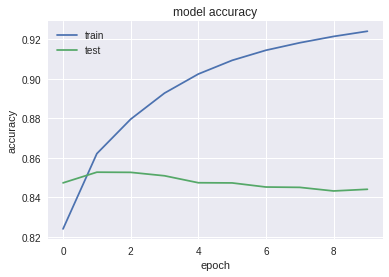

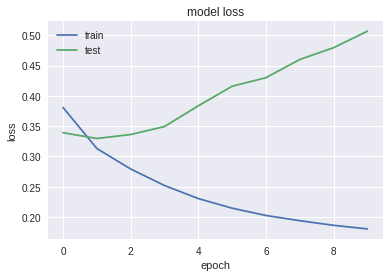

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()